In [183]:
import cv2
import matplotlib.pyplot as plt
from fonctions_image import *

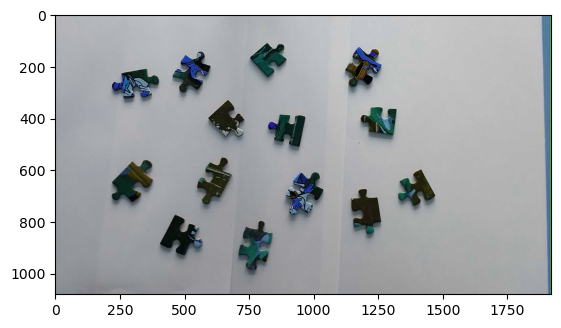

In [184]:
puzzle = cv2.imread('../nos_puzzles/yakari.jpg')
image_test = cv2.imread("../frame_test.jpg")

plt.imshow(image_test)

Found 15 valid pieces
Piece areas: [12098, 17469, 13236, 16431, 15300, 13428, 13900, 14397, 13964, 18135, 13457, 17206, 15548, 15137, 16723]

Piece 0:
Position: (1877, 0)
Size: (43, 1080)
Area: 12098

Piece 1:
Position: (1097, 70)
Size: (189, 303)
Area: 17469

Piece 2:
Position: (732, 86)
Size: (193, 201)
Area: 13236

Piece 3:
Position: (430, 119)
Size: (199, 232)
Area: 16431

Piece 4:
Position: (196, 188)
Size: (236, 182)
Area: 15300

Piece 5:
Position: (565, 309)
Size: (193, 202)
Area: 13428

Piece 6:
Position: (1159, 334)
Size: (192, 182)
Area: 13900

Piece 7:
Position: (800, 360)
Size: (195, 197)
Area: 14397

Piece 8:
Position: (526, 527)
Size: (180, 247)
Area: 13964

Piece 9:
Position: (197, 539)
Size: (205, 224)
Area: 18135

Piece 10:
Position: (1309, 574)
Size: (190, 210)
Area: 13457

Piece 11:
Position: (869, 583)
Size: (198, 246)
Area: 17206

Piece 12:
Position: (1126, 646)
Size: (166, 248)
Area: 15548

Piece 13:
Position: (381, 747)
Size: (212, 220)
Area: 15137

Piece 14:
Pos

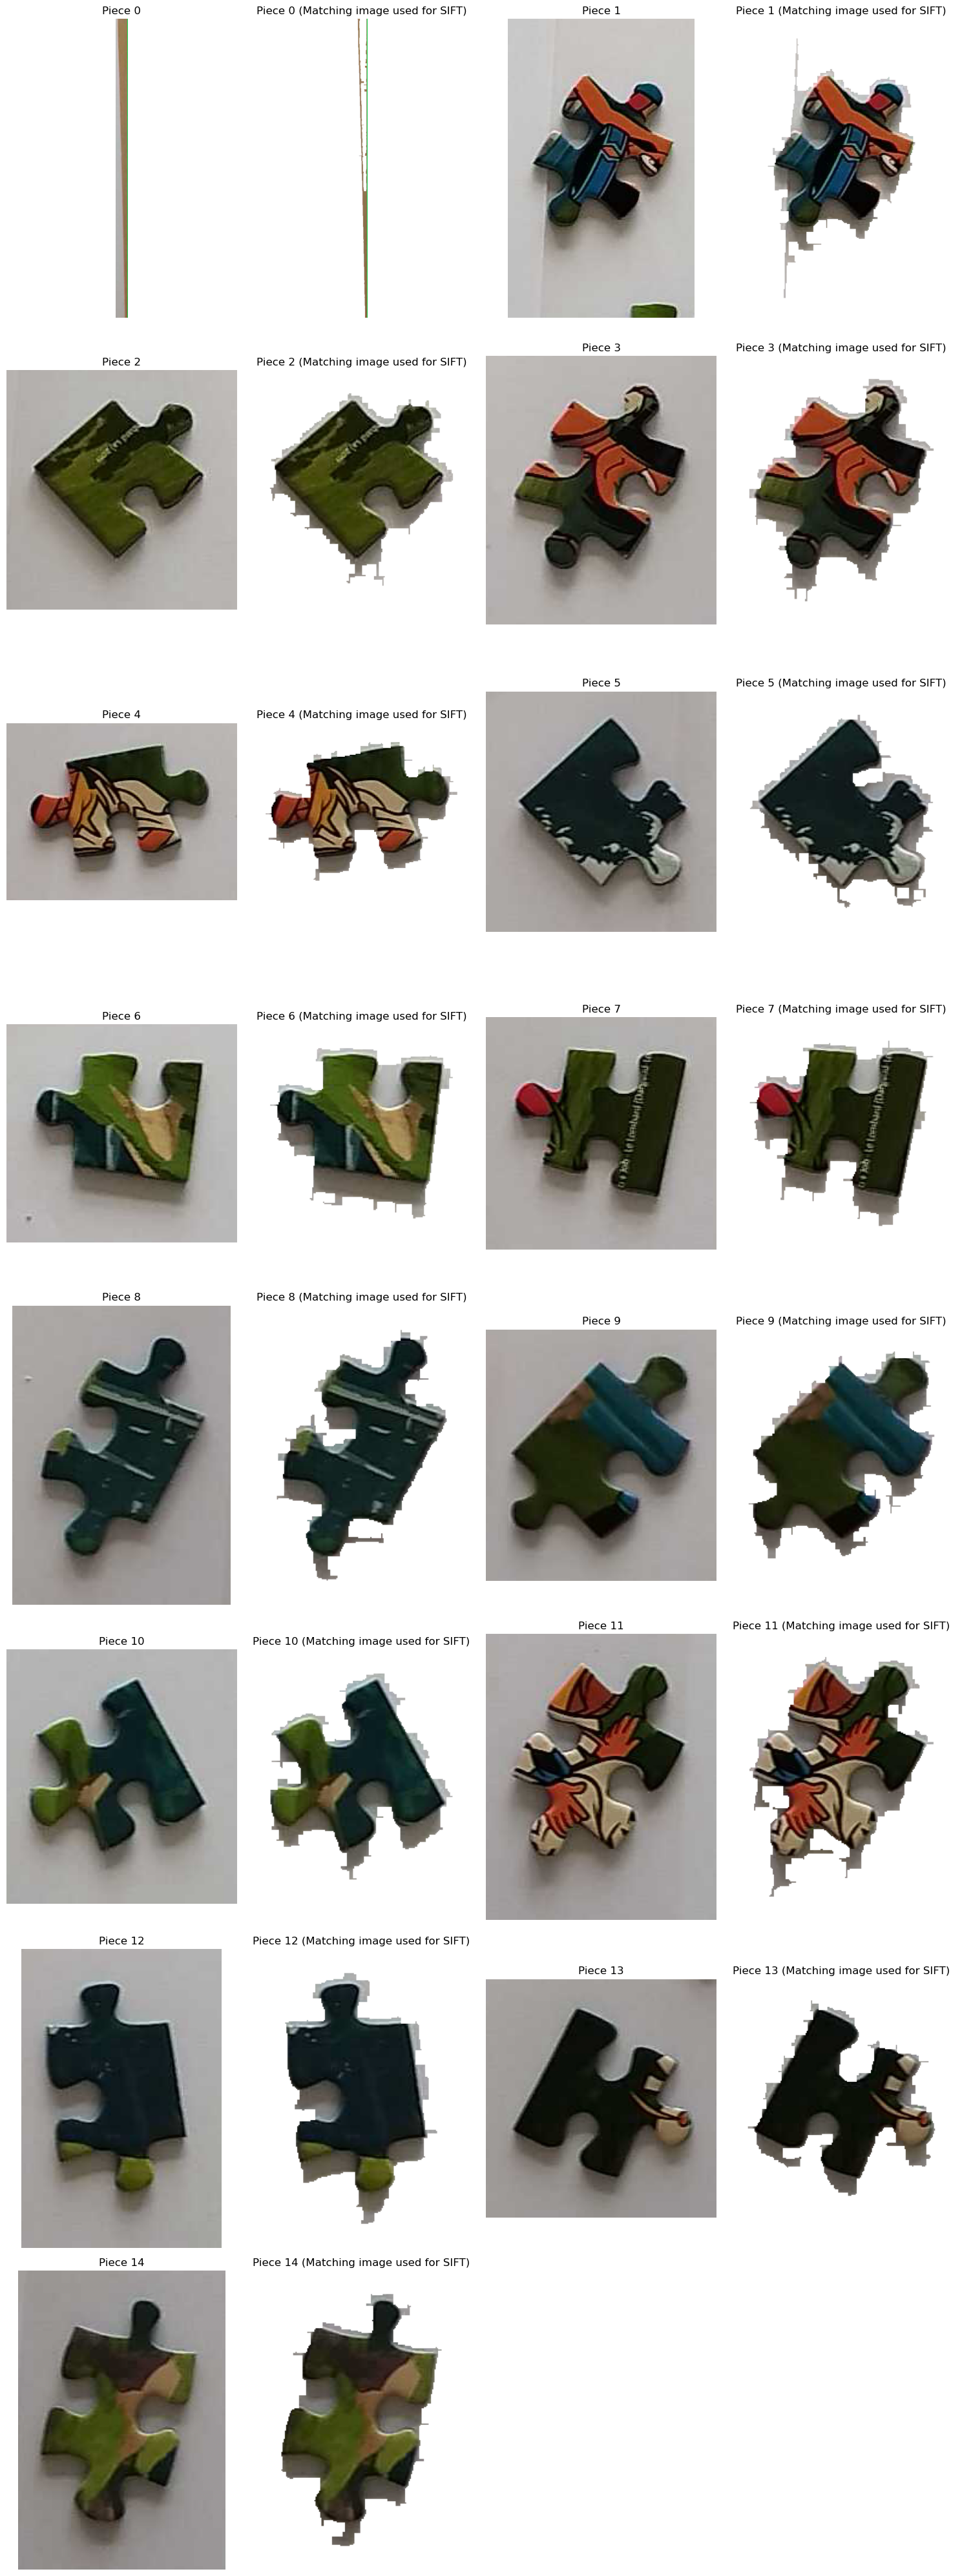

In [185]:
pieces = extract_pieces(image_test)
show_found_pieces(pieces)


### Idée : on réduit le masque pour enlever toutes les features au bord

### AJOUT : filtre feature edges

In [186]:
piece = pieces[2]
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(piece['matching_image'], None)
keypoints_filtered, descriptors_filtered = filter_keypoints_by_mask(keypoints, descriptors, piece['binary_mask'])

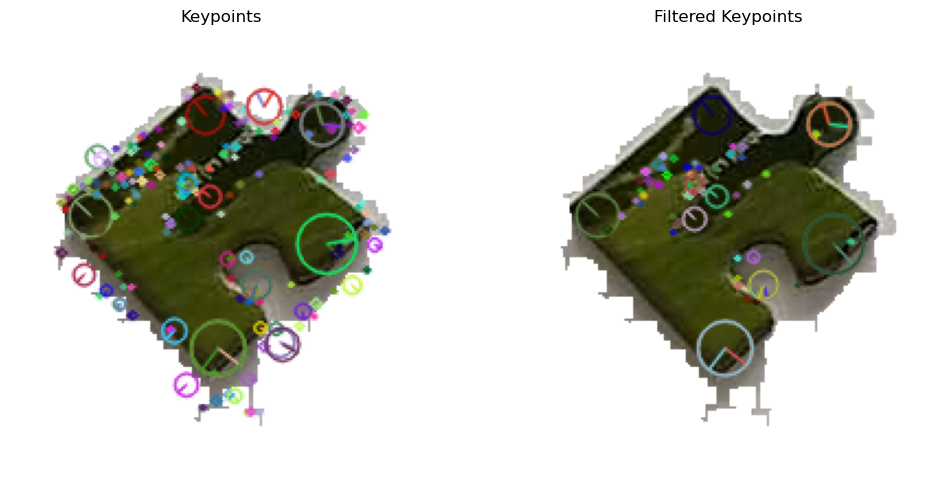

In [187]:
image_with_keypoints = cv2.drawKeypoints(
    piece['matching_image'], keypoints, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Shows size and orientation
)
image_filtered_keypoints = cv2.drawKeypoints(
    piece['matching_image'], keypoints_filtered, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Shows size and orientation
)

# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image with keypoints on the first subplot
ax[0].imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
ax[0].set_title('Keypoints')
ax[0].axis('off')  # Hide axes

# Show the filtered keypoints image on the second subplot
ax[1].imshow(cv2.cvtColor(image_filtered_keypoints, cv2.COLOR_BGR2RGB))
ax[1].set_title('Filtered Keypoints')
ax[1].axis('off')  # Hide axes

# Display the images
plt.show()


## Fonctions

In [188]:
def calculate_matches(piece, puzzle, keypoints, descriptors, keypoints_full, descriptors_full):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors, descriptors_full, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 1*n.distance:  # Lowe's ratio test (pas sûr de le garder car features peuvent être proches)
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]
    #La spatial consistency crée un bottleneck majeur
    good_matches = get_spatially_consistent_matches_optimized(good_matches, keypoints_full, piece['size'])

    print("Matches and their distances:")
    for idx, match in enumerate(good_matches):
        print(f"Match {idx + 1}: Distance = {match.distance:.2f}")
        
    # Draw matches
    match_img = cv2.drawMatches(
        piece['matching_image'], keypoints,
        puzzle, keypoints_full,
        good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchesThickness=3,
        matchColor=(0, 255, 0),
    )
    # Display matches 
    print(f"Found {len(good_matches)} good matches")
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    
    return good_matches


### Sift

In [189]:
def calculate_keypoints_sift(piece, puzzle):
    
    sift = cv2.SIFT_create()
    keypoints_full, descriptors_full = sift.detectAndCompute(puzzle, None)
    
    keypoints, descriptors = sift.detectAndCompute(piece['matching_image'], None)

    keypoints_filtered, descriptors_filtered = filter_keypoints_by_mask(keypoints, descriptors, piece['binary_mask'])
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_filtered, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_filtered, descriptors_filtered, keypoints_full, descriptors_full
     

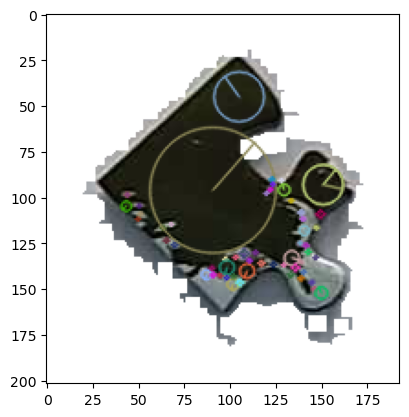

In [190]:
piece = pieces[5]
keypoints_piece, descriptors_piece, keypoints_full, descriptors_full = calculate_keypoints_sift(piece, puzzle)

Matches and their distances:
Match 1: Distance = 484.57
Match 2: Distance = 574.30
Found 2 good matches


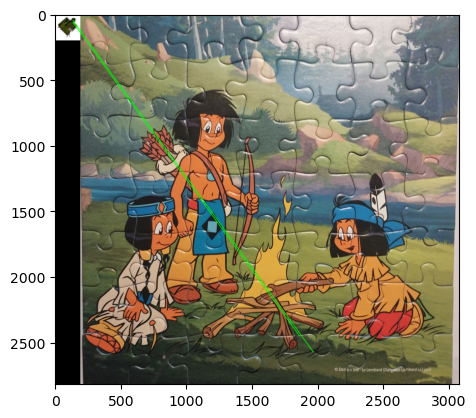

In [200]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece, keypoints_full, descriptors_full)

In [199]:
canvas, _ = calculate_transform(piece, matches, keypoints_piece, keypoints_full, puzzle, byhand=False)
plt.imshow(canvas)

error: OpenCV(4.10.0) C:\b\abs_daut97tdpo\croot\opencv-suite_1722029138522\work\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


### Akaze

In [193]:
def calculate_keypoints_akaze(piece, puzzle) :
    
    akaze = cv2.AKAZE_create()

    keypoints_full, descriptors_full = akaze.detectAndCompute(puzzle, None)
    
    keypoints_piece, descriptors_piece = akaze.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
)
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece, keypoints_full, descriptors_full

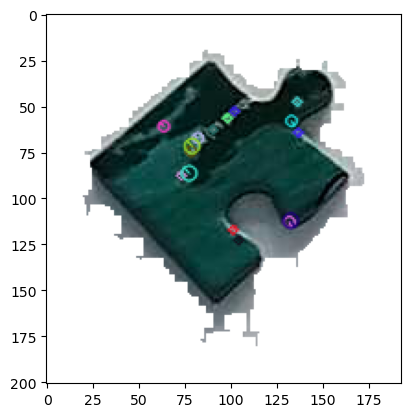

In [194]:
piece = pieces[2]
keypoints_piece, descriptors_piece, keypoints_full, descriptors_full = calculate_keypoints_akaze(piece, puzzle)

Matches and their distances:
Match 1: Distance = 484.57
Match 2: Distance = 574.30
Found 2 good matches


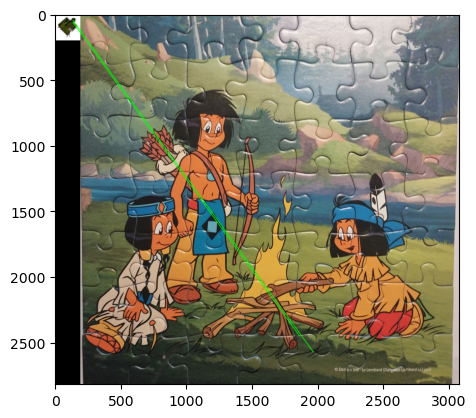

In [195]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece, keypoints_full, descriptors_full)

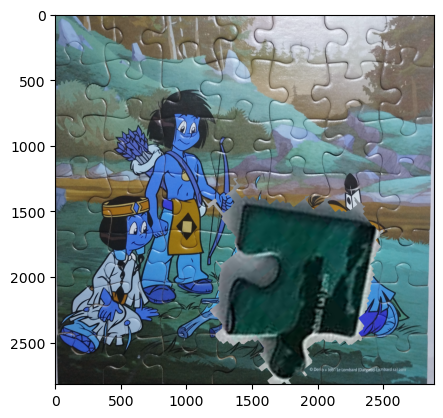

In [196]:
canvas, _ = calculate_transform(piece, matches, keypoints_piece, keypoints_full, puzzle, byhand=True)
plt.imshow(canvas)